[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/witchapong/build-ai-based-applications/blob/main/vision/1_image_classification_fastai.ipynb)

# Image Classification
In this notebook, we'll learn how to build a deep learning (ML) model for classifying food images. We'll use [fastai](https://docs.fast.ai/) which is a convenient high-level AI/ML toolkit built on top of [Pytorch](https://pytorch.org/), one of the two most popular frameworks for building Neural Network based ML model developed by Facebook (the other one is [TensorFlow](https://www.tensorflow.org/api_docs) by Google).

In [3]:
# # install Kaggle's API
# !pip install kaggle
# # download dataset from Kaggle
# !kaggle datasets download harishkumardatalab/food-image-classification-dataset
# # unzip image data
# !unzip food-image-classification-dataset.zip -d data
# # install fastai
# !pip install -Uqq fastbook

In [4]:
import os
import os.path as op
import shutil
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from pathlib import Path

# Explore label

In [5]:
# read all image directories into a DataFrame
img_df = pd.DataFrame({"image_path": glob("data/Food Classification dataset/*/*")})
img_df["label"] = img_df["image_path"].apply(lambda x: x.split("/")[2])
img_df = img_df[["image_path", "label"]]

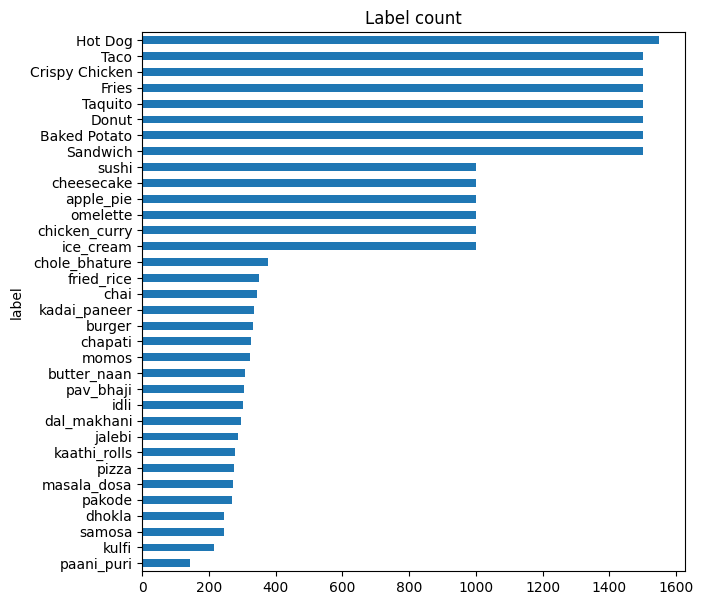

In [6]:
_ = img_df["label"].value_counts(ascending=True).plot(kind="barh", figsize=(7,7))
_ = plt.title("Label count")

# Split data

In [7]:
# separate train & test data >> let's split 10% of each class for testing
train_img_df, test_img_df = train_test_split(img_df, test_size=.1, stratify=img_df["label"])

In [8]:
train_img_df["label"].value_counts(normalize=True)

,proportion
label,
Hot Dog,0.064836
Sandwich,0.062835
Donut,0.062835
Crispy Chicken,0.062835
Taco,0.062835
Baked Potato,0.062835
Taquito,0.062835
Fries,0.062835
ice_cream,0.041890


In [9]:
test_img_df["label"].value_counts(normalize=True)

,proportion
label,
Hot Dog,0.064908
Sandwich,0.062814
Taco,0.062814
Donut,0.062814
Taquito,0.062814
Baked Potato,0.062814
Crispy Chicken,0.062814
Fries,0.062814
omelette,0.041876


# Train model

In [10]:
import fastbook
fastbook.setup_book()
from fastbook import *

Mounted at /content/gdrive


In [11]:
fields = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
   get_x=ColReader("image_path"),
   get_y=ColReader("label"),
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # GrandparentSplitter(valid_name='validation')
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

In [12]:
dls = fields.dataloaders(train_img_df)

In [13]:
dls.vocab

['Baked Potato', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Sandwich', 'Taco', 'Taquito', 'apple_pie', 'burger', 'butter_naan', 'chai', 'chapati', 'cheesecake', 'chicken_curry', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'ice_cream', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'omelette', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa', 'sushi']

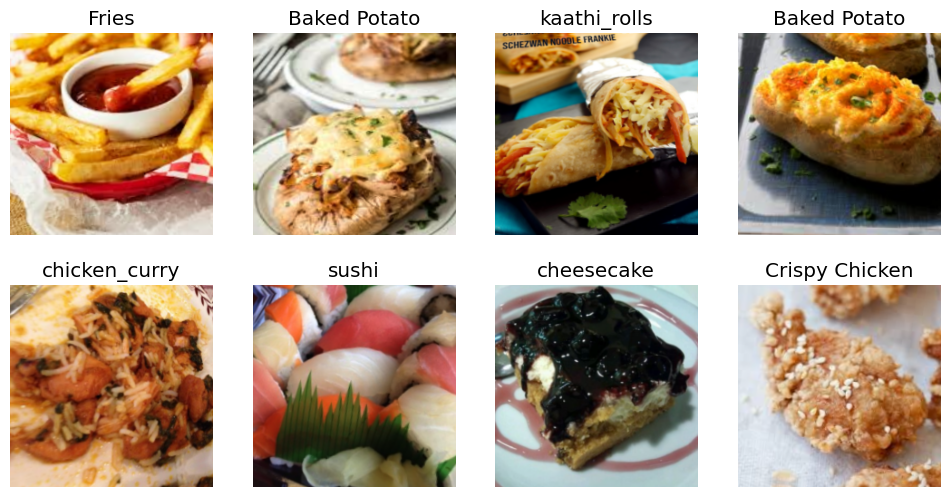

In [16]:
dls.train.show_batch(max_n=8, nrows=2)

In [17]:
learner = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 155MB/s]


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full con

SuggestedLRs(valley=0.0030199517495930195)

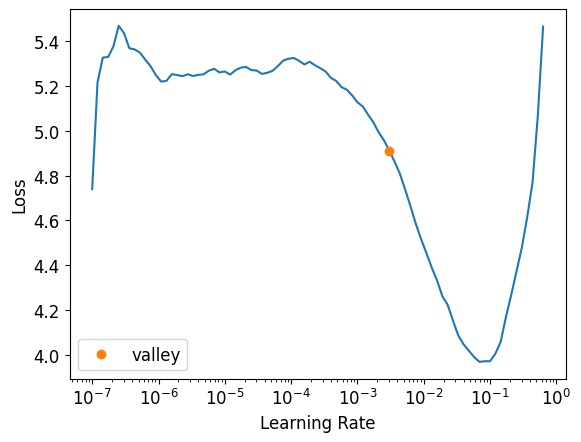

In [18]:
learner.lr_find() # หา learning rate ที่เหมาะสม

In [19]:
learner.fine_tune(epochs=6, freeze_epochs=1, base_lr=0.0012)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.720331,0.947861,0.271585,0.728415,03:09


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.989852,0.609189,0.174540,0.825460,03:15
1,0.663934,0.492227,0.146847,0.853153,03:14
2,0.485577,0.413291,0.118920,0.881080,03:14
3,0.348503,0.387607,0.113800,0.886200,03:15
4,0.250674,0.360368,0.105888,0.894112,03:17
5,0.219432,0.355637,0.103793,0.896207,03:14


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in by

# Evaluation

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


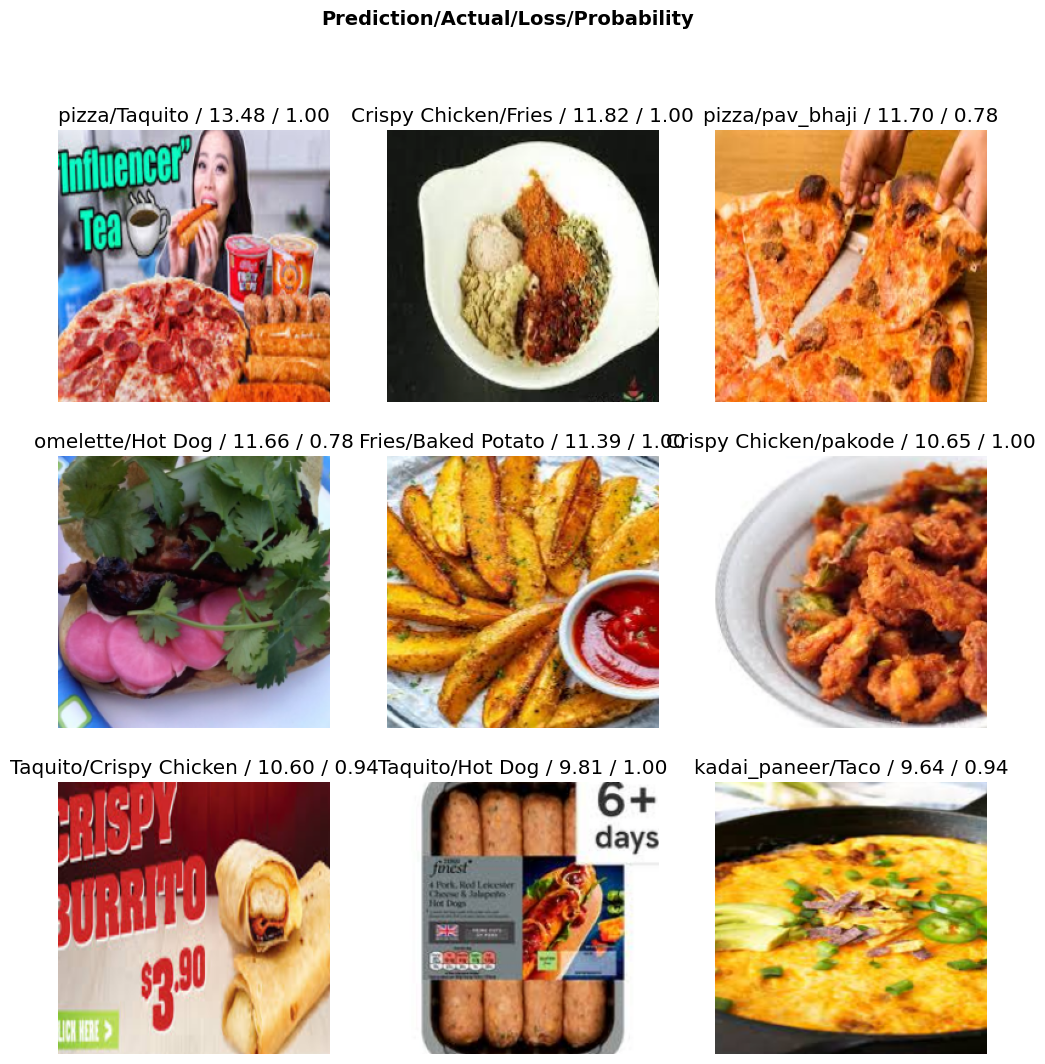

In [26]:
interp = Interpretation.from_learner(learner)
interp.plot_top_losses(9, figsize=(12,12))

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


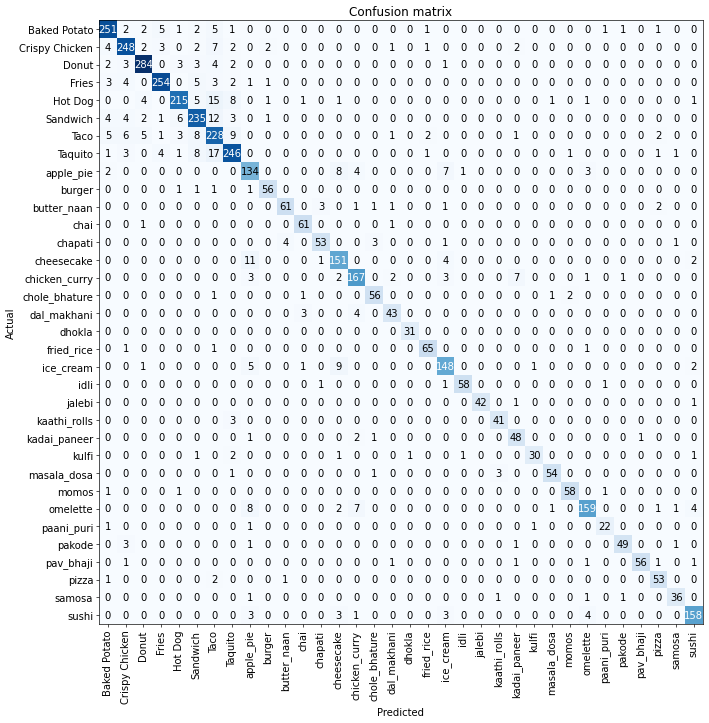

In [21]:
clf_interp = ClassificationInterpretation.from_learner(learner)
clf_interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [22]:
clf_interp.most_confused(min_val=5)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[('Taquito', 'Taco', 17),
 ('Hot Dog', 'Taco', 15),
 ('Sandwich', 'Taco', 12),
 ('cheesecake', 'apple_pie', 11),
 ('Taco', 'Taquito', 9),
 ('ice_cream', 'cheesecake', 9),
 ('Hot Dog', 'Taquito', 8),
 ('Taco', 'Sandwich', 8),
 ('Taquito', 'Sandwich', 8),
 ('apple_pie', 'cheesecake', 8),
 ('omelette', 'apple_pie', 8),
 ('Crispy Chicken', 'Taco', 7),
 ('apple_pie', 'ice_cream', 7),
 ('chicken_curry', 'kadai_paneer', 7),
 ('omelette', 'chicken_curry', 7),
 ('Sandwich', 'Hot Dog', 6),
 ('Taco', 'Crispy Chicken', 6),
 ('Baked Potato', 'Fries', 5),
 ('Baked Potato', 'Taco', 5),
 ('Fries', 'Sandwich', 5),
 ('Hot Dog', 'Sandwich', 5),
 ('Taco', 'Baked Potato', 5),
 ('Taco', 'Donut', 5),
 ('ice_cream', 'apple_pie', 5)]

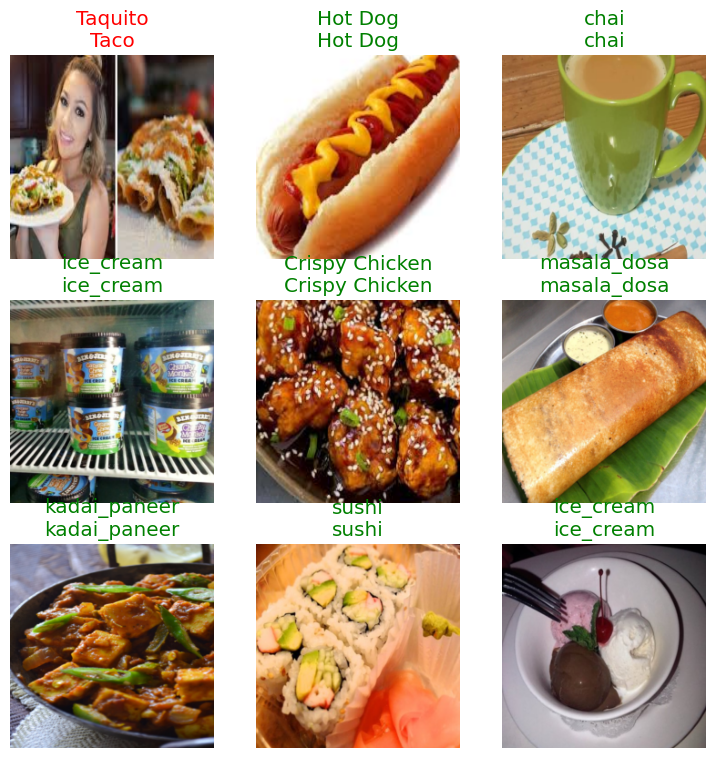

In [23]:
learner.show_results(shuffle=True)

sushi


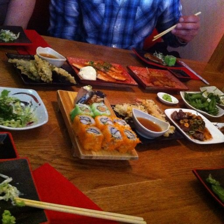

In [24]:
rand_img = test_img_df.sample(1)
rand_img_path = rand_img["image_path"].values[0]
rand_img_label = rand_img["label"].values[0]

print(rand_img_label)
Image.open(rand_img_path).resize((224, 224))

In [25]:
learner.predict(rand_img_path)

('sushi',
 tensor(33),
 tensor([1.1280e-05, 4.7736e-06, 1.2162e-05, 1.1051e-05, 3.6726e-05, 3.5035e-06, 1.2377e-04, 3.3699e-05, 3.4376e-04, 1.1464e-04, 2.6518e-04, 2.1317e-05, 3.9078e-06, 4.6847e-04, 5.9513e-04, 1.5323e-04,
         9.4551e-05, 1.5114e-03, 5.4263e-05, 1.9913e-04, 5.9163e-05, 3.3710e-05, 4.0660e-05, 5.4475e-04, 5.1718e-05, 1.9573e-04, 6.5543e-05, 2.2371e-03, 9.9454e-05, 2.4612e-05, 7.1859e-03, 1.5932e-02,
         6.7377e-05, 9.6940e-01]))